<table class="m01-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/yy/dviz-course/blob/master/docs/m12-maps/lab12.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a href="https://yyahn.com/dviz-course/m12-maps/lab12/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on Github</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/yy/dviz-course/master/docs/m12-maps/lab12.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View raw on Github</a>
  </td>
</table>

# Module 12: Maps

Let's draw some maps. 🗺🧐

## A dotmap with Altair

Let's start with altair.

When your dataset is large, it is nice to enable something called "json data transformer" in altair. What it does is, instead of generating and holding the whole dataset in the memory, to transform the dataset and save into a temporary file. This makes the whole plotting process much more efficient. For more information, check out: https://altair-viz.github.io/user_guide/data_transformers.html

In [1]:
import altair as alt

# saving data into a file rather than embedding into the chart
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

We need a dataset with geographical coordinates. This `zipcodes` dataset contains the location and zipcode of each zip code area.

In [2]:
from vega_datasets import data

zipcodes_url = data.zipcodes.url
zipcodes = data.zipcodes()
zipcodes.head()

,zip_code,latitude,longitude,city,state,county
0,00501,40.922326,-72.637078,Holtsville,NY,Suffolk
1,00544,40.922326,-72.637078,Holtsville,NY,Suffolk
2,00601,18.165273,-66.722583,Adjuntas,PR,Adjuntas
3,00602,18.393103,-67.180953,Aguada,PR,Aguada
4,00603,18.455913,-67.145780,Aguadilla,PR,Aguadilla


In [3]:
zipcodes = data.zipcodes(dtype={'zip_code': 'category'})
zipcodes.head()

,zip_code,latitude,longitude,city,state,county
0,00501,40.922326,-72.637078,Holtsville,NY,Suffolk
1,00544,40.922326,-72.637078,Holtsville,NY,Suffolk
2,00601,18.165273,-66.722583,Adjuntas,PR,Adjuntas
3,00602,18.393103,-67.180953,Aguada,PR,Aguada
4,00603,18.455913,-67.145780,Aguadilla,PR,Aguadilla


In [4]:
zipcodes.zip_code.dtype

CategoricalDtype(categories=['00501', '00544', '00601', '00602', '00603', '00604',
                  '00605', '00606', '00610', '00611',
                  ...
                  '99919', '99921', '99922', '99923', '99925', '99926',
                  '99927', '99928', '99929', '99950'],
, ordered=False, categories_dtype=object)

Btw, you'll have fewer issues if you pass URL instead of a dataframe to `alt.Chart`.

### Let's draw it

Now we have the dataset loaded and start drawing some plots. Let's say you don't know anything about map projections. What would you try with geographical data? Probably the simplest way is considering (longitude, latitude) as a Cartesian coordinate and directly plot them.

In [5]:
alt.Chart(zipcodes_url).mark_circle().encode(
    x='longitude:Q',
    y='latitude:Q',
)

alt.Chart(...)

Actually this itself is a map projection called [Equirectangular projection](https://en.wikipedia.org/wiki/Equirectangular_projection). This projection (or almost a *non-projection*) is super straight-forward and doesn't require any processing of the data. So, often it is used to just quickly explore geographical data. As you dig deeper, you still want to think about which map projection fits your need best. Don't just use equirectangular projection without any thoughts!

Anyway, let's make it look slighly better by reducing the size of the circles and adjusting the aspect ratio. **Q: Can you adjust the width and height?**

In [6]:
# YOUR SOLUTION HERE
alt.Chart(zipcodes_url).mark_circle(size=1).encode(
    x='longitude:Q',
    y='latitude:Q',
).properties(
    width=1024,
    height=600
)

alt.Chart(...)

But, a much better way to do this is explicitly specifying that they are lat, lng coordinates by using `longitude=` and `latitude=`, rather than `x=` and `y=`. If you do that, altair automatically adjust the aspect ratio. **Q: Can you try it?**

In [7]:
# YOUR SOLUTION HERE
alt.Chart(zipcodes_url).mark_circle(size=5).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
).properties(
    width=1024,
    height=600
)

alt.Chart(...)

Because the [American empire is far-reaching and complicated](https://www.youtube.com/watch?v=ASSOQDQvVLU), the information density of this map is very low (although interesting). Moreover, the US looks twisted because a default projection that is not focused on the US is used.

A common projection for visualizing US data is [AlbersUSA](https://bl.ocks.org/mbostock/5545680), which uses [Albers (equal-area) projection](https://en.wikipedia.org/wiki/Albers_projection). This is a standard projection used in United States Geological Survey and the United States Census Bureau. Albers USA contains a composition of US main land, Alaska, and Hawaii.

To use it, we  call `project` method and specify which variables are `longitude` and `latitude`.

**Q: use the `project` method to draw the map in the AlbersUsa projection.**

In [8]:
# YOUR SOLUTION HERE
alt.Chart(zipcodes_url).mark_circle(size=7).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
).project(
    'albersUsa'
).properties(
    width=1024,
    height=600
)

alt.Chart(...)

Now we're talking. 😎

Let's visualize the large-scale zipcode patterns. We can use the fact that the zipcodes are hierarchically organized. That is, the first digit captures the largest area divisions and the other digits are about smaller geographical divisions.

Altair provides some data transformation functionalities. One of them is extracting a substring from a variable.

In [9]:
import altair as alt

alt.data_transformers.enable('json')

alt.Chart(zipcodes_url).mark_circle(size=2).transform_calculate(
    first_digit=alt.expr.substring(alt.datum.zip_code, 0, 1)
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color='first_digit:N',
).project(
    type='albersUsa'
).properties(
    width=700,
    height=400,
)

alt.Chart(...)

For each row (`datum`), you obtain the `zip_code` variable and get the substring (imagine Python list slicing), and then you call the result `first_digit`. Now, you can use this `first_digit` variable to color the circles. Also note that we specify `first_digit` as a *nominal* variable, not quantitative, to obtain a categorical colormap. But we can also play with it too.

**Q: Why don't you extract the first two digits, name it as `two_digits`, and declare that as a quantitative variable? Any interesting patterns? What does it tell us about the history of US?**

In [10]:
# YOUR SOLUTION HERE
alt.Chart(zipcodes_url).mark_circle(size=2).transform_calculate(
    two_digits=alt.expr.substring(alt.datum.zip_code, 0, 2)
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color='two_digits:Q',
).project(
    type='albersUsa'
).properties(
    width=700,
    height=400,
)

alt.Chart(...)

The boundaries between states and states are more obvious.

Also, the number increases from east to west, meaning that the US expanded from east to west.

**Q: also try it with declaring the first two digits as a categorical variable**

In [11]:
alt.Chart(zipcodes_url).mark_circle(size=2).transform_calculate(
    two_digits=alt.expr.substring(alt.datum.zip_code, 0, 2)
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color=alt.Color('two_digits:N')
).project(
    type='albersUsa'
).properties(
    width=700,
    height=400
)

alt.Chart(...)

In [12]:
zipcodes

,zip_code,latitude,longitude,city,state,county
0,00501,40.922326,-72.637078,Holtsville,NY,Suffolk
1,00544,40.922326,-72.637078,Holtsville,NY,Suffolk
2,00601,18.165273,-66.722583,Adjuntas,PR,Adjuntas
3,00602,18.393103,-67.180953,Aguada,PR,Aguada
4,00603,18.455913,-67.145780,Aguadilla,PR,Aguadilla
...,...,...,...,...,...,...
42044,99926,55.094325,-131.566827,Metlakatla,AK,Prince Wales Ketchikan
42045,99927,55.517921,-132.003244,Point Baker,AK,Prince Wales Ketchikan
42046,99928,55.395359,-131.675370,Ward Cove,AK,Ketchikan Gateway
42047,99929,56.449893,-132.364407,Wrangell,AK,Wrangell Petersburg


In [13]:
# Implement

# YOUR SOLUTION HERE

alt.Chart(zipcodes_url).mark_circle(size=2).transform_calculate(
    two_digits=alt.expr.substring(alt.datum.zip_code, 0, 2)
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color=alt.Color('two_digits:N', scale=alt.Scale(scheme='category20'))
).project('albersUsa').properties(
    width=700,
    height=400
)

alt.Chart(...)

Btw, you can always click "view source" or "open in Vega Editor" to look at the json object that **defines** this visualization. You can embed this json object on your webpage and easily put up an interactive visualization.

**Q: Can you put a tooltip that displays the zipcode when you mouse-over?**

In [14]:
# YOUR SOLUTION HERE
alt.Chart(zipcodes_url).mark_circle(size=2).transform_calculate(
    two_digits=alt.expr.substring(alt.datum.zip_code, 0, 2),
    zip_code = alt.datum.zip_code
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color=alt.Color('two_digits:N', scale=alt.Scale(scheme='category20')),
    tooltip=[
            alt.Tooltip('zip_code:N', title='ZIP Code'),
            alt.Tooltip('city:N', title='City'),
            alt.Tooltip('state:N', title='State')
        ]
).project('albersUsa').properties(
    width=700,
    height=400
)

alt.Chart(...)

## Choropleth

Let's try some choropleth now. Vega datasets have US county / state boundary data (`us_10m`) and world country boundary data (`world-110m`). You can take a look at the boundaries on GitHub (they renders topoJSON files):

- https://github.com/vega/vega-datasets/blob/main/data/us-10m.json
- https://github.com/vega/vega-datasets/blob/main/data/world-110m.json

If you click "Raw" then you can take a look at the actual file, which is hard to read.

Essentially, each file is a large dictionary with the following keys.

In [15]:
usmap = data.us_10m()
usmap.keys()

dict_keys(['type', 'transform', 'objects', 'arcs'])

In [16]:
usmap['type']

'Topology'

In [17]:
usmap['transform']

{'scale': [0.003589294092944858, 0.0005371535195261037],
 'translate': [-179.1473400003406, 17.67439566600018]}

This `transformation` is used to *quantize* the data and store the coordinates in integer (easier to store than float type numbers).

https://github.com/topojson/topojson-specification#212-transforms

In [18]:
usmap['objects'].keys()

dict_keys(['counties', 'states', 'land'])

This data contains not only county-level boundaries (objects) but also states and land boundaries.

In [19]:
usmap['objects']['land']['type'], usmap['objects']['states']['type'], usmap['objects']['counties']['type']

('MultiPolygon', 'GeometryCollection', 'GeometryCollection')

`land` is a multipolygon (one object) and `states` and `counties` contains many geometrics (multipolygons) because there are many states (counties). We can look at a state as a set of arcs that define it. It's `id` captures the identity of the state and is the key to link to other datasets.

In [20]:
state1 = usmap['objects']['states']['geometries'][1]
state1

{'type': 'MultiPolygon',
 'arcs': [[[10337]],
  [[10342]],
  [[10341]],
  [[10343]],
  [[10834, 10340]],
  [[10344]],
  [[10345]],
  [[10338]]],
 'id': 15}

The `arcs` referred here is defined in `usmap['arcs']`.

In [21]:
usmap['arcs'][:10]

[[[15739, 57220], [0, 0]],
 [[15739, 57220], [29, 62], [47, -273]],
 [[15815, 57009], [-6, -86]],
 [[15809, 56923], [0, 0]],
 [[15809, 56923], [-36, -8], [6, -210], [32, 178]],
 [[15811, 56883], [9, -194], [44, -176], [-29, -151], [-24, -319]],
 [[15811, 56043], [-12, -216], [26, -171]],
 [[15825, 55656], [-2, 1]],
 [[15823, 55657], [-19, 10], [26, -424], [-26, -52]],
 [[15804, 55191], [-30, -72], [-47, -344]]]

It seems pretty daunting to work with this dataset, right? But fortunately people have already built tools to handle such data.

In [22]:
states = alt.topo_feature(data.us_10m.url, 'states')

In [23]:
states

UrlData({
  format: TopoDataFormat({
    feature: 'states',
    type: 'topojson'
  }),
  url: 'https://cdn.jsdelivr.net/npm/vega-datasets@v1.29.0/data/us-10m.json'
})

Can you find a mark for geographical shapes from here https://altair-viz.github.io/user_guide/marks/index.html# and draw the states?

In [24]:
# YOUR SOLUTION HERE
alt.Chart(states).mark_geoshape(stroke='white')

alt.Chart(...)

And then project it using the `albersUsa`?

In [25]:
# YOUR SOLUTION HERE
alt.Chart(states).mark_geoshape(stroke='white').project('albersUsa').properties(
    width=800,
    height=600
)

alt.Chart(...)

Can you do the same thing with counties and draw county boundaries?

In [26]:
# YOUR SOLUTION HERE
us_counties = alt.topo_feature(data.us_10m.url, 'counties')

base = alt.Chart(us_counties).transform_calculate(
    id='format(datum.id, "05d")'
)

alt.Chart(us_counties).mark_geoshape(stroke='white').project(
    type='albersUsa'
).transform_calculate(
    id_str='toString(datum.id)'
).properties(
    width=700,
    height=400
)

alt.Chart(...)

Let's load some county-level unemployment data.

In [27]:
unemp_data = data.unemployment(sep='\t')
unemp_data.head()

,id,rate
0,1001,0.097
1,1003,0.091
2,1005,0.134
3,1007,0.121
4,1009,0.099


This dataset has unemployment rate. When? I don't know. We don't care about data provenance here because the goal is quickly trying out choropleth. But if you're working with a real dataset, you should be very sensitive about the provenance of your dataset. Make sure you understand where the data came from and how it was processed.

Anyway, for each county specified with `id`. To combine two datasets, we use "Lookup transform" - https://vega.github.io/vega/docs/transforms/lookup/. Essentially, we use the `id` in the map data to look up (again) `id` field in the `unemp_data` and then bring in the `rate` variable. Then, we can use that `rate` variable to encode the color of the `geoshape` mark.

In [30]:
from IPython.display import HTML

chart = alt.Chart(us_counties).mark_geoshape().project(
    type='albersUsa'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(unemp_data, 'id', ['rate'])
).encode(
    color='rate:Q'
).properties(
    width=700,
    height=400
)

# The chart cannot display normally in this ipynb file. I have to perform it like the following.

chart.save('output.html')

There you have it, a nice choropleth map. 😎


## Raster visualization with datashader

Although many geovisualizations use vector graphics, raster visualization is still useful especially when you deal with images and lots of datapoints. Datashader is a package that aggregates and visualizes a large amount of data very quickly. Given a *scene* (visualization boundary, resolution, etc.), it quickly aggregate the data and produce **pixels** and send them to you.

To appreciate its power, we need a fairly large dataset. Let's use NYC taxi trip dataset on Kaggle: https://www.kaggle.com/kentonnlp/2014-new-york-city-taxi-trips You can download even bigger trip data from NYC open data website: https://opendata.cityofnewyork.us/data/

Ah, and you want to install the datashader, bokeh, and holoviews first if you don't have them yet.  

```sh
uv add datashader bokeh holoviews jupyter-bokeh
```

or

```sh
pip install datashader bokeh holoviews jupyter-bokeh
```

or

```sh
conda install datashader bokeh holoviews jupyter-bokeh
```
    

In [31]:
import pandas as pd
import datashader as ds
from datashader import transfer_functions as tf
from colorcet import fire

Because the dataset is pretty big, let's use a small sample first. For this visualization, we only keep the dropoff location.

In [32]:
nyctaxi_small = pd.read_csv('~/Downloads/archive/nyc_taxi_data_2014.csv', nrows=10000,
                            usecols=['dropoff_longitude', 'dropoff_latitude'])
nyctaxi_small.head()

,dropoff_longitude,dropoff_latitude
0,-73.982227,40.731790
1,-73.960449,40.763995
2,-73.986626,40.765217
3,-73.979863,40.777050
4,-73.984367,40.720524


Although the dataset is different, we can still follow the example here: https://datashader.org/getting_started/Introduction.html

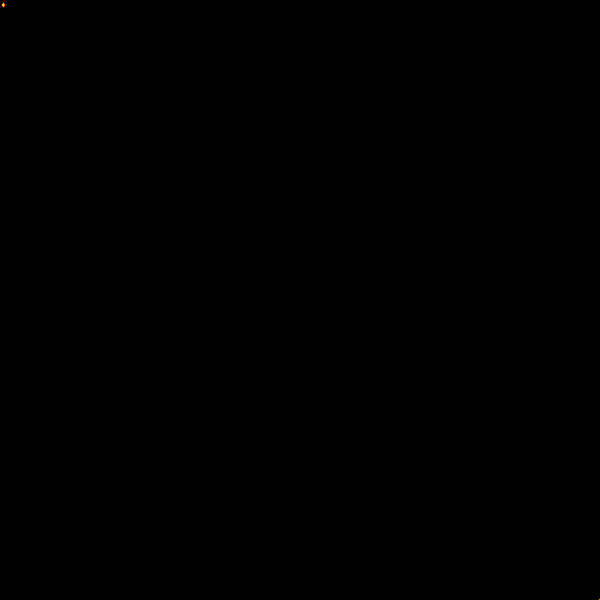

In [33]:
agg = ds.Canvas().points(nyctaxi_small, 'dropoff_longitude', 'dropoff_latitude')
tf.set_background(tf.shade(agg, cmap=fire),"black")

Why can't we see anything? Wait, do you see the small dots on the left top? Can that be New York City? Maybe we don't see anything because some people travel very far? or because the dataset has some missing data?

**Q: Can you first check whether there are NaNs? Then drop them and draw the map again?**

In [34]:
# YOUR SOLUTION HERE
nyctaxi_small.isnull().values.any()

True

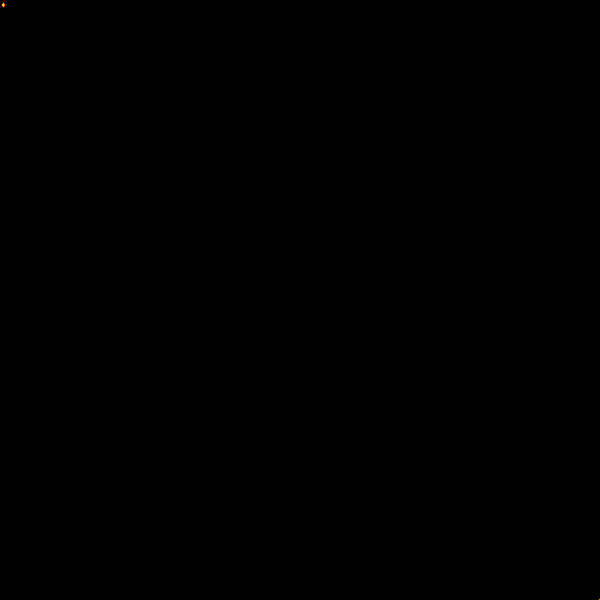

In [35]:
# drop the rows with NaN and then draw the map again.

# YOUR SOLUTION HERE
nyctaxi_small.dropna()
agg = ds.Canvas().points(nyctaxi_small, 'dropoff_longitude', 'dropoff_latitude')
tf.set_background(tf.shade(agg, cmap=fire),"black")

So it's not about the missing data.

**Q: Can you identify the issue and draw the map like the following?**

hint: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.between.html this method may be helpful.

In [36]:
# You can use multiple cells to figure out what's going on.

# YOUR SOLUTION HERE
nyctaxi_small_filtered = nyctaxi_small[
    nyctaxi_small['dropoff_longitude'].between(-74.05, -73.75) &
    nyctaxi_small['dropoff_latitude'].between(40.63, 40.85)
]


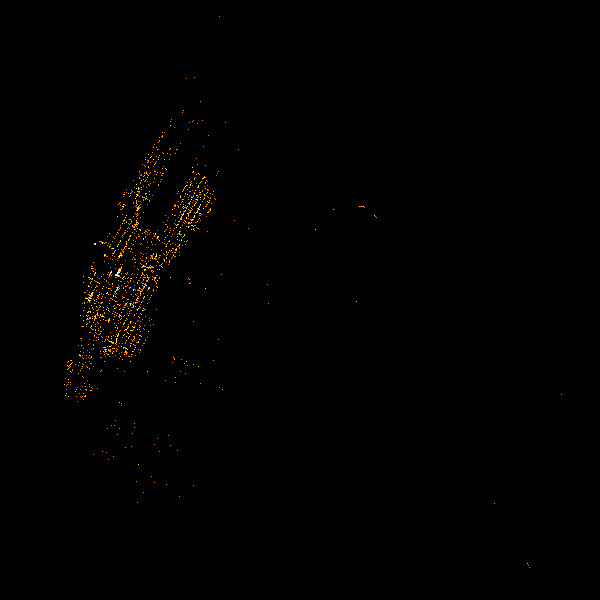

In [37]:
agg = ds.Canvas().points(nyctaxi_small_filtered, 'dropoff_longitude', 'dropoff_latitude')
tf.set_background(tf.shade(agg, cmap=fire), "black")

Do you see the black empty space at the center? That looks like the Central Park. This is cool, but it'll be awesome if we can explore the data interactively.

Ok, now let's get serious by loading the whole dataset. It may take some time. Apply the same data cleaning procedure.

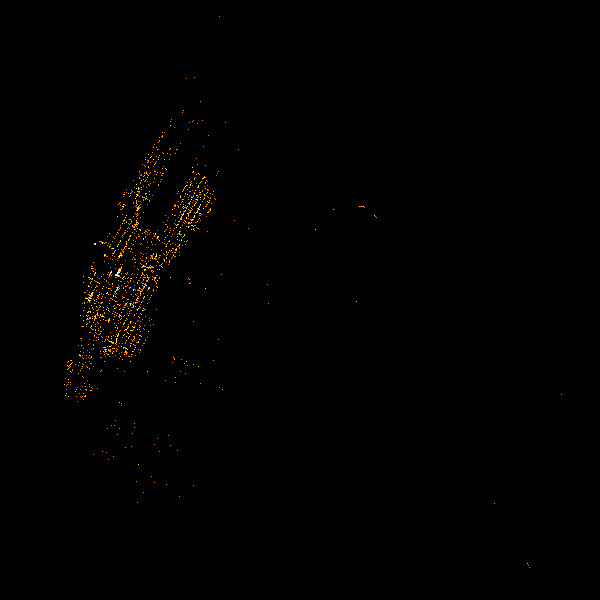

In [38]:
# YOUR SOLUTION HERE
nyctaxi_small_filtered.dropna()
agg = ds.Canvas().points(nyctaxi_small_filtered, 'dropoff_longitude', 'dropoff_latitude')
tf.set_background(tf.shade(agg, cmap=fire),"black")

Can you feed the data directly to datashader to reproduce the static plot, this time with the full data?

In [39]:
# YOUR SOLUTION HERE
nyctaxi = pd.read_csv('~/Downloads/archive/nyc_taxi_data_2014.csv',
                            usecols=['dropoff_longitude', 'dropoff_latitude'])
nyctaxi_filtered = nyctaxi[
    nyctaxi['dropoff_longitude'].between(-74.05, -73.75) &
    nyctaxi['dropoff_latitude'].between(40.63, 40.85)
]

Wow, that's fast. Also it looks cool!

Let's try the interactive version from here: https://datashader.org/getting_started/Introduction.html

In [40]:
nyctaxi_filtered

,dropoff_longitude,dropoff_latitude
0,-73.982227,40.731790
1,-73.960449,40.763995
2,-73.986626,40.765217
3,-73.979863,40.777050
4,-73.984367,40.720524
...,...,...
14999994,-74.000675,40.725737
14999995,-73.991287,40.692535
14999996,-73.776505,40.740790
14999997,-74.005953,40.710922


We currently only have longitudes and latitudes. We need to conver them into a coordinate system that datashader understands.

In [41]:
from datashader.utils import lnglat_to_meters

df = nyctaxi_filtered
df['dropoff_x'], df['dropoff_y'] = lnglat_to_meters(df.dropoff_longitude, df.dropoff_latitude)


/var/folders/m3/yrfkxbps2dj234x7zfm0t6bh0000gn/T/ipykernel_78426/1009409252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dropoff_x'], df['dropoff_y'] = lnglat_to_meters(df.dropoff_longitude, df.dropoff_latitude)
/var/folders/m3/yrfkxbps2dj234x7zfm0t6bh0000gn/T/ipykernel_78426/1009409252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dropoff_x'], df['dropoff_y'] = lnglat_to_meters(df.dropoff_longitude, df.dropoff_latitude)


Now we can visualize the data interactively. See https://datashader.org/getting_started/Introduction.html

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
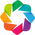

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [dropoff_x,dropoff_y]   (R,G,B,A)

In [42]:
import holoviews as hv
import colorcet as cc

from holoviews.element.tiles import EsriImagery
from holoviews.operation.datashader import datashade
hv.extension('bokeh')


# YOUR SOLUTION HERE
import datashader as ds

hv.extension('bokeh')

map_tiles  = EsriImagery().opts(alpha=0.5, width=900, height=480, bgcolor='black')
points     = hv.Points(df, ['dropoff_x', 'dropoff_y'])
taxi_trips = datashade(points, x_sampling=1, y_sampling=1, cmap=cc.fire, width=900, height=480)

map_tiles * taxi_trips

**Q: how many rows (data points) are we visualizing right now?**

In [43]:
# YOUR SOLUTION HERE
points.shape[0]

14630593

That's a lot of data points. If we are using a vector format, it is probably hopeless to expect any interactivity because you need to move that many points! Yet, datashader + holoviews + bokeh renders everything almost in real time!

## Leaflet

Another useful tool is Leaflet. It allows you to use various map tile data (Google maps, Open streetmap, ...) with many types of marks (points, heatmap, etc.). [Leaflet.js](https://leafletjs.com) is one of the easiest options to do that on the web, and there is a Python bridge of it: https://github.com/jupyter-widgets/ipyleaflet.

You can install it simply by

```sh
pip install ipyleaflet
```

It is quite easy to display an interactive map with it. You can also add markers, polygons, etc.

from ipyleaflet import Map, Marker

center = (52.204793, 360.121558)

m = Map(center=center, zoom=15)

marker = Marker(location=center, draggable=True)
m.add(marker);

display(m)

marker.location = center


ipyleaflet lets you use various basemaps. You can find the list of available basemaps here: https://leaflet-extras.github.io/leaflet-providers/preview/

For instance, let's use OpenStreetMap and zoom into the Luddy School building.

In [44]:
from ipyleaflet import basemaps, Map

center = (39.172681590059604, -86.5233788123735)
zoom = 17

Map(basemap=basemaps.OpenStreetMap.HOT, center=center, zoom=zoom)

Map(center=[39.172681590059604, -86.5233788123735], controls=(ZoomControl(options=['position', 'zoom_in_text',…

**Q: can you identify a combination of location, zoom-level, and basemap to create an interesting(?) map?**

In [45]:
# YOUR SOLUTION HERE
def make_map(center, zoom, basemap):
    return Map(center=center, zoom=zoom, basemap=basemap)

my_map = make_map(center=center, zoom=zoom, basemap=basemaps.OpenStreetMap.Mapnik)
my_map

Map(center=[39.172681590059604, -86.5233788123735], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Let's create a heatmap. First create a small list of random points around the center.

In [46]:
center

(39.172681590059604, -86.5233788123735)

In [47]:
import random

random_points = [
    [
        random.uniform(center[0]-0.01, center[0]+0.01),
        random.uniform(center[1]-0.01, center[1]+0.01),
        random.uniform(0, 5)
    ] for x in range(100)
]
random_points[:2]

[[39.17498854964118, -86.52857625756043, 1.4355866856485033],
 [39.17426141353528, -86.52657534755983, 2.181990325549676]]

**Q: using these random points, can you create a heatmap?**

documentation: https://ipyleaflet.readthedocs.io/en/latest/layers/heatmap.html

In [48]:
from ipyleaflet import Map, Heatmap, CircleMarker

# YOUR SOLUTION HERE
heat = Heatmap(
    locations=random_points,
    radius=15,                 
    blur=10,                  
    max=5                      
)

my_map.add_layer(heat)

for lat, lon, w in random_points:
    my_map.add_layer(CircleMarker(
        location=(lat, lon),
        radius=int(3 + w),   
        color="red",
        fill_color="red"
    ))

my_map

Map(bottom=12803269.0, center=[39.172681590059604, -86.5233788123735], controls=(ZoomControl(options=['positio…

## Summary

Ok! In this assignment, we played with dot maps, choropleth maps, and heatmaps. Although sometimes we can simply show the data points that reveal the geography, usually we need to have a basemap upon which we put our data.

### Tools: what to use when?

Some packages like `datashader` allows us to work with tons of data points and visualize and interact with them on a map. Altair/Vega can provide a very simple way to create standard map visualizations that can be used in a web pages and dashboards. Finally, `ipyleaflet` allows us to create highly interactive maps. The focus is more on showing a specific basemap and overlaying data points on it, while most other packages are more focused on showing the data in question on a basic map.

There are many other tools as well. For example, `plotly` can create 3D globes and `folium` can create interactive maps. `R` also has a lot of tools for creating maps and frequently used for geographical data analysis and visualization.



